1. Check whether decoding latent vectors that are drawn from the prior distribution yields reasonable sequences.
2. Check whether we can accurately reconstruct sequences after encoding them (i.e. encode sequence, then decode back, then check whether we get something close to what we started with)

## Preliminaries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from Bio import SeqIO
from collections import Counter
import re
from autoencoder.modules.model import VAE
from pathlib import Path 
# help(VAE)
# help(MSA_Dataset)

In [3]:
MSA_id = "PF00565"
data_path = f"msas/real/processed/{MSA_id}"

Load binarized MSA

In [4]:
## read multiple sequence alignment in binary representation
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# for some reason, msa_binary is float64 so first transform it to float 32 for later use
msa_binary = msa_binary.to(torch.float32)
# Number of sequences
n_total = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([7161, 93, 21])

Load sequence labels

In [5]:
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
        seq_names = pickle.load(file_handle)
seq_names[:10]

['A0A3P7MX59_9BILA/1-72',
 'A0A4W6CL59_LATCA/173-263',
 'A0A0Q3PK25_AMAAE/1-60',
 'A0A151P0H3_ALLMI/1-60',
 'A0A1V4JH04_PATFA/1-60',
 'A0A2U3YW32_LEPWE/1-60',
 'A0A7J8HDF3_MOLMO/1-60',
 'L5LE70_MYODS/1-60',
 'A0A444U038_ACIRT/1-60',
 'A0A6P6NTU7_CARAU/1-60']

If we are dealing with the family from Detlefsen, aka PF00144, we have a file with the phyla of the species from which these protiens are obtained that we'll want to load too in order to visualize the preservation of phylogeny by the embeddings:

In [6]:
if MSA_id == "PF00144":
    # each sequence has phylum labelled in the following file
    labelled_seq_fn = "data/Ding/raw/PF00144_full_length_sequences_labeled.fasta"
    phyla = {}
    with open(labelled_seq_fn, 'r') as file_handle:
        for record in SeqIO.parse(file_handle, "fasta"):
            label = record.id
            phylum = re.search(r'\[([^\]]+)\]', record.description).group(1)
            phyla[label] = phylum
    # order the phyla labels according to the order of sequences in our processed MSA (i.e. according to seq_names)
    ordered_msa_phyla = []
    for label in seq_names:
        label = label.split("/")[0]
        if label in phyla:
            ordered_msa_phyla.append(phyla[label])
        else:
            ordered_msa_phyla.append("Unknown")
    # Count the number of sequences in each phylum
    count = Counter(ordered_msa_phyla)
    sorted_count = sorted(count.items(), key=lambda item: item[1], reverse=True)
    for phylum, count in sorted_count:
        print(f"{phylum}: {count}")

Load model

In [7]:
model_name = "model_ld2_wd0_epoch100_2024-06-10.pt"
model_path = f"saved_models/real/{MSA_id}/{model_name}"
model = VAE(nl = nl, nc = nc, dim_latent_vars=2) # initiate to have the right architecture for loading
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Load mapping between integers and amino acid characters

In [8]:
with open(f"{data_path}/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)

# now let's create the inverse mapping
# In our integer encoding of proteins, we've encoded several different amino acid characters as 0
# For decoding purposes, we will decode all 0's as '-'
del aa_index['.'], aa_index['X'], aa_index['B'], aa_index['Z'], aa_index['J'], 


idx_to_aa_dict = {}
for k, v in aa_index.items():
    idx_to_aa_dict[v] = k

# Part 1: Decoding draws from the prior

In [9]:
# draws from the prior to be decoded
# z has to be a torch.tensor with a size of (num_seqs, dim_latent_space)
num_seqs = n_total
dim_latent_space = model.dim_latent_vars
z = torch.randn(num_seqs, dim_latent_space)

# decode to amino acid probabilities
with torch.no_grad():
    log_p = model.decoder(z)
    p = torch.exp(log_p)
p = p.numpy()
p.shape

(7161, 93, 21)

In [10]:
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = np.argmax(p, -1)
seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    seqs.append("".join(seq))
seqs[::10] # print every 10 sequences to compare with real sequences

['NI-APRL-EPWAFEAREFLRKLLIGKEVCFTVEYSTSTGREYGTVFLGGKNIAELLLKEGWAKLRD---------------------------',
 'GVDAPEGAQPYSAEALAWLTSLILGKRVRVQLLRRDQYNRIVAMVYVRGKNVSLEMLKAGWATVYEQAGYGGKLEEFKKVEAEAK--------',
 'S-RPPR-EIPYMFEAREFLRKKLIGKKVNVTVDYIDNFEKTCCTVTIGGVNIAEALVSKGLATVVRYRQRSSHYDELLAAEQKAEKSGKGL--',
 'GVDAPELAQPYSAEALEWLRSYILNRRVRAYIYRRDQYDRVVATVWVRRRDVGLEMLKAGLATVYEKMGFGDFEKKYRAAEEKAKRKKVGMWA',
 'GIKCPRTDEKIGNEAKAFVEDRLLTSKVTVTVLVISQSGVPIGLVIHPGGNIAEKLLEAGLAEVVDWQSGSSIMSKLRKAEQTAKALGKGLF-',
 'GIRAPAIREPFAEEARFFVESRLLQRDVEIILEGV-NNNNFVGSVLHPKGNIAEALLREGLAKCVDSSIVTGGAEKLRAAEKAAKEKRLRLWK',
 '--------EDFGHEAAEYLSEVLLGKEIRATIHERDTSGGKVKGQGTGGSSVNAVLLEKGLARLERRWKQKKALDKLEEFQEEAKKKRLLMWR',
 '----------------KFLEKKLLERNVKIEYEDVDKSGTFLGNLYSSKVSFAEELLKQGLAELNTFGLRTPEAKKLLAAENEAKKAKKGLWK',
 'LIDAPELDEPHGRESREYLRQLLLGKDVKCPQTGKDQYGRIFADVFLPFKDLQETMVRQGWAWAYE-Y----PNDVYRAAETAARQAKRGLWA',
 'GIDAPETAQPFAKEAKAELTSEILGRTVFVKLLRKDQYGRVVAHVFRRAKNVSDELLKEGYAVVYR---------------------------',
 '-------------QGRKF

Now let's compare to some real sequences. 

To do so, first let's retrieve an integer encoded version of the MSA (instead of binary). We have pickled such an encoding with file name `seq_msa.pkl`

In [11]:
with open(f"{data_path}/seq_msa.pkl", 'rb') as file_handle:
    real_seqs_int = pickle.load(file_handle)
# Alternatively, since `argmax` works for extracting position of the 1 from the one hot encoded vectors:
real_seqs_int2 = torch.argmax(msa_binary, -1)
assert torch.tensor(real_seqs_int).equal(real_seqs_int2)
print(real_seqs_int.shape)

(7161, 93)


Now we can decode the integers to amino acid characters using `idx_to_aa_dict`.

In [12]:
real_seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_dict[idx] for idx in real_seqs_int[i,:]]
    real_seqs.append("".join(seq))
real_seqs[::10] # print every 10 sequences to compare with reconstructed sequences

['------------------------------------SNQNFVGSVIHPKGNIAELLLNEGFAKCVDWSIATSGPEVLRAAEKRAKDKKLRLWR',
 '-----------------------------------DKAGNFIGWLHIEGVNLSVALVEQALSRVHFTAERSPYCKALLAAQDAAKQRKEKVWS',
 '----------------------------------VEYNEKNVSYATLYEEDIGKALVEEGFILVSKRRELEKIMKEYQEAESRAKKERLNLW-',
 '----------------------------TIEVETVDRAGTFLGSLWESKTNMVVALLQAGLAKLQNFASRILDAHLLARAEQSAIHQRL----',
 '---------------------------VFVEVESMDRGGNFIGRLTTVGNSASFMLVQAGLAKVHEAYG--PNYKQLIEAEEKCRKERIGVW-',
 '--------------------------QVEVEVESMDKAGNFIGWLHAEGANLSVALVEQGLSRVHFTAERSPYYKALLAAEEAAKRKKEKVWA',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEHALSKVHFTAERSPYYKSLLSAEEAAKQKKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEQALSRVHFTAERSPYCKALLAAQDAAKQRKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGLNLSVALVEHALSKVHFTAERSPYYKALLAAEEGAKQKKEKVWS',
 '--------------------------YVQIDVFRRDQYDRAVAMVWYRWRNLSVDLLREGLAVVYRQAGYGGMKETFEKEEAKAKRVRRGLWS',
 '------------------

What's the proportion of characters that match?

In [13]:
correct = 0
total = 0
for (seq, real_seq) in zip(seqs, real_seqs[:num_seqs]):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(seq, real_seq)])
  total += len(seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 179297
total: 665973
Percentage correct: 26.92


What's the distribution of percentage of accurately predicted aa's across sequences?

(array([  11.,   35.,  157.,  229.,  672., 1130., 1337.,  840.,  966.,
         578.,  381.,  175.,  177.,  130.,   65.,   87.,   50.,   39.,
          20.,   21.,   12.,   15.,    7.,   11.,    5.,    4.,    2.,
           0.,    3.,    2.]),
 array([0.04301075, 0.07240143, 0.10179211, 0.1311828 , 0.16057348,
        0.18996416, 0.21935484, 0.24874552, 0.2781362 , 0.30752688,
        0.33691756, 0.36630824, 0.39569892, 0.42508961, 0.45448029,
        0.48387097, 0.51326165, 0.54265233, 0.57204301, 0.60143369,
        0.63082437, 0.66021505, 0.68960573, 0.71899642, 0.7483871 ,
        0.77777778, 0.80716846, 0.83655914, 0.86594982, 0.8953405 ,
        0.92473118]),
 <BarContainer object of 30 artists>)

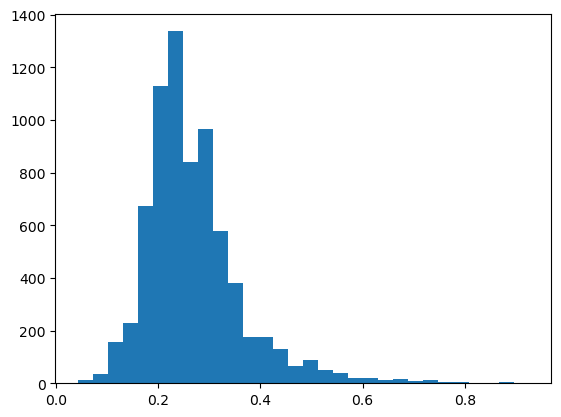

In [14]:
acc = []
for (predicted_seq, real_seq) in zip(seqs, real_seqs):
  n_correct = sum([predicted_c == real_c for (predicted_c, real_c) in zip(predicted_seq, real_seq)])
  acc.append(n_correct)

acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)

### Compare first and second-order statistics of draws from prior and 

# Part 2: Reconstructing sequences

Now let's not just draw from the prior and decode, but draw from the posterior defined by a given real sequence and then decode. In other words, let's see whether our VAE is good at reconstructing sequences:

First, we encode the real sequences

In [15]:
with torch.no_grad():
  mu, sigma = model.encoder(msa_binary)
mu.shape, sigma.shape

(torch.Size([7161, 2]), torch.Size([7161, 2]))

We can view the `mu` vectors as embeddings of the proteins. Moreover, for one of the families, we can color by the phylum of the species from which the sample is taken. Here's a function for plotting for this family

In [16]:
def plot_colored_pf00144(embeddings, plot_top=True) -> None:
    """
    plot_top controls whether we plot the same phyla as detlefsen or the top 10 most common phyla
    """
    detlefsen_phyla_dict = {"Acidobacteria": "#693B9E", 
                        "Actinobacteria": "#FBCB90", 
                        "Bacteroidetes": "#E3181B",
                        "Chloroflexi": "#F3A19F", 
                        "Cyanobacteria": "#FA7F00", 
                        "Deinococcus-Thermus": "#A8CCE0", 
                        "Firmicutes": "#36A038", 
                        "Fusobacteria": "#B2E289", 
                        "Proteobacteria": "#147AB0"}
    colors = set(detlefsen_phyla_dict.values())
    top_phyla_list = [phylum for phylum, _ in sorted_count[:10] if phylum != "Other"]
    top_phyla_dict = {}
    # Assign the corresponding color to each phyla in the top_phyla_list as in detlefsen_phyla_dict
    for phylum in top_phyla_list:
        if phylum in detlefsen_phyla_dict:
            top_phyla_dict[phylum] = detlefsen_phyla_dict[phylum]
    # For the remaining phyla, assign a color that is not in the set of colors already used
    colors = list(colors - set(top_phyla_dict.values()) )
    for phylum in top_phyla_list:
        if phylum not in top_phyla_dict:
            top_phyla_dict[phylum] = colors.pop()
    phyla_dict = top_phyla_dict if plot_top else detlefsen_phyla_dict
    # Create a scatter plot
    plt.figure(figsize=(5, 4))
    for phylum in phyla_dict:
        idx = [i for i, ph in enumerate(ordered_msa_phyla) if ph == phylum]
        plt.scatter(mu[idx, 0], mu[idx, 1], s=6, label=phylum, c = phyla_dict[phylum])

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('2D Embeddings Visualization')
    plt.legend()
    plt.show()

Now let's actually plot

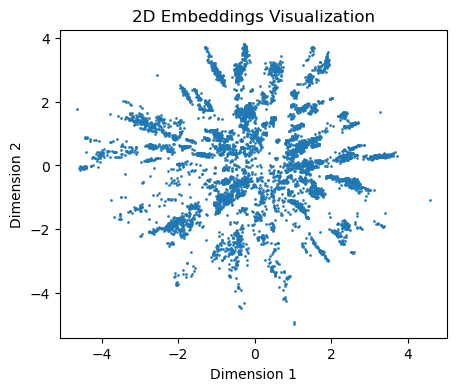

In [17]:
plt.figure(figsize=(5, 4))
plt.scatter(mu[:, 0], mu[:, 1], s=1, alpha=0.9)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Embeddings Visualization')
plt.show()
if MSA_id == "PF00144":
    plot_colored_pf00144(mu)

If the embeddings are in more than two dimensions, we can plot first two pca components

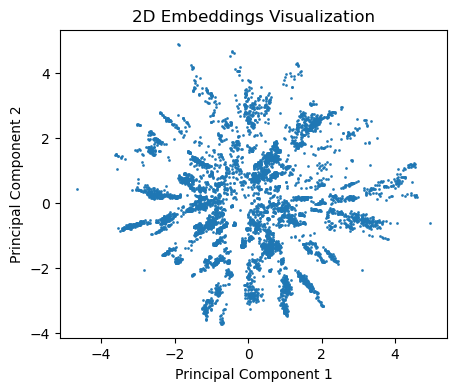

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu)
plt.figure(figsize=(5, 4))
plt.scatter(mu_pca[:, 0], mu_pca[:, 1], s=1, alpha=0.9)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Embeddings Visualization')
plt.show()
if MSA_id == "PF00144":
    plot_colored_pf00144(mu_pca)


Let's save them to a csv

In [19]:
# Convert to dataframe
embeddings = pd.DataFrame(mu.numpy(), columns=[f"dim{i}" for i in range(mu.shape[1])])
# Add names of sequences as a column
with open(f"{data_path}/seq_names.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
embeddings.insert(0, "id", seq_names)
# Save to csv
model_name = Path(model_name).stem
import os 
os.makedirs(f"embeddings/{MSA_id}", exist_ok=True)
embeddings.to_csv(f"embeddings/{MSA_id}/{model_name}_embeddings.csv", index=False)

Now we decode the $\mu$'s

In [20]:
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
p.shape

torch.Size([7161, 93, 21])

Now we covert probablities into actual protein sequences by choosing the most likely amino acid at each position.


In [21]:
max_prob_idx = torch.argmax(p, -1)

To check accuracy, i.e. the percentage of amino acids that match, we can simply run

In [22]:
# Proportion of amino acids correctly recovered
real_seqs_int = torch.tensor(real_seqs_int)
torch.sum(real_seqs_int == max_prob_idx)/real_seqs_int.nelement()

tensor(0.7463)

Alternatively, we can decode the integer `max_prob_idx` to character 

In [23]:
max_prob_idx = max_prob_idx.numpy()
recon_seqs = []
for i in range(len(max_prob_idx)):
    recon_seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    recon_seqs.append("".join(recon_seq))
# print every 10 sequences to compare with real sequences
recon_seqs[::10]

['-----------------------------------DNYGAECAHVTYQKKDIALGLVENGLAKVVKRKELQKMVKEYKNAEQSAKKERLGIWR',
 '----------------------------------MDKAGNFIGWLHIEGVNLSVALVEHALSKVHFTAERSPYYKALLSAEEAAKQRKEKVWS',
 '-----------------------------------DYNEAECPHVTLQKDDIALGLVEEGLAMVDKRKELQKMVKEYLEAEESAKKERLGLWE',
 '--------------------------QVHIVVETVDRYGNFVASVYYSKGNVAKALLENGLAKVQKRGLLTKDAEELLAAEQSAKRARLGIWR',
 '-----------------------------V--E--DKAGNFIGYLHIEGKNLSVELVENGLAKVHETAEHSSYYKSLLSAEEQAKQKRIGMWK',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEHALSKVHFTAERSPYYKALLSAEEAAKQKKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEQALSKVHFTAERSPYYKALLAAEEAAKQRKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEQALSKVHFTAERSPYYKALLAAEEAAKQRKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEQALSKVHFTAERSPYYKALLAAEEAAKQRKEKVWS',
 '--------------------------QVHIVVETVDRTGTFVASVYYSKGNVGKALLKNGLAKVQKRGGLTKDAEELLAAEQSAKRARLGIWR',
 '------------------

In [24]:
# print every 10 sequences
real_seqs[::10]

['------------------------------------SNQNFVGSVIHPKGNIAELLLNEGFAKCVDWSIATSGPEVLRAAEKRAKDKKLRLWR',
 '-----------------------------------DKAGNFIGWLHIEGVNLSVALVEQALSRVHFTAERSPYCKALLAAQDAAKQRKEKVWS',
 '----------------------------------VEYNEKNVSYATLYEEDIGKALVEEGFILVSKRRELEKIMKEYQEAESRAKKERLNLW-',
 '----------------------------TIEVETVDRAGTFLGSLWESKTNMVVALLQAGLAKLQNFASRILDAHLLARAEQSAIHQRL----',
 '---------------------------VFVEVESMDRGGNFIGRLTTVGNSASFMLVQAGLAKVHEAYG--PNYKQLIEAEEKCRKERIGVW-',
 '--------------------------QVEVEVESMDKAGNFIGWLHAEGANLSVALVEQGLSRVHFTAERSPYYKALLAAEEAAKRKKEKVWA',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEHALSKVHFTAERSPYYKSLLSAEEAAKQKKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGVNLSVALVEQALSRVHFTAERSPYCKALLAAQDAAKQRKEKVWS',
 '--------------------------QVEVEVESMDKAGNFIGWLHIEGLNLSVALVEHALSKVHFTAERSPYYKALLAAEEGAKQKKEKVWS',
 '--------------------------YVQIDVFRRDQYDRAVAMVWYRWRNLSVDLLREGLAVVYRQAGYGGMKETFEKEEAKAKRVRRGLWS',
 '------------------

and then run

In [25]:
correct = 0
total = 0
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  correct += sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  total += len(real_seq)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")

correct: 496987
total: 665973
Percentage correct: 74.63


What's the distribution of percentage of accurately reconstructed aa's across sequences?

(array([  3.,   0.,   6.,   7.,  20.,  28.,  53.,  72., 102.,  78., 149.,
        131., 220., 184., 194., 321., 236., 349., 278., 471., 386., 579.,
        400., 706., 520., 708., 337., 361., 173.,  89.]),
 array([0.20430108, 0.23082437, 0.25734767, 0.28387097, 0.31039427,
        0.33691756, 0.36344086, 0.38996416, 0.41648746, 0.44301075,
        0.46953405, 0.49605735, 0.52258065, 0.54910394, 0.57562724,
        0.60215054, 0.62867384, 0.65519713, 0.68172043, 0.70824373,
        0.73476703, 0.76129032, 0.78781362, 0.81433692, 0.84086022,
        0.86738351, 0.89390681, 0.92043011, 0.94695341, 0.9734767 ,
        1.        ]),
 <BarContainer object of 30 artists>)

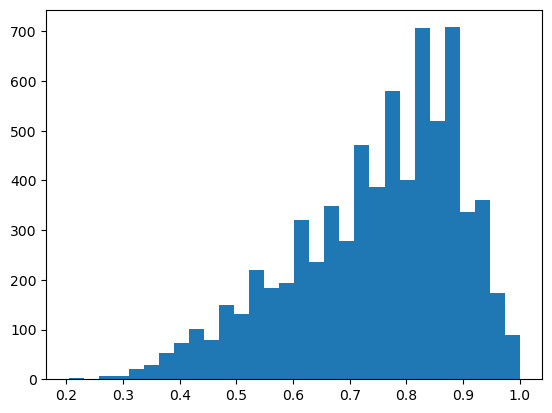

In [26]:
acc = []
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  n_correct = sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  acc.append(n_correct)

acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)